In [2]:
import re
import glob
import sys
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
plt.rcParams["figure.figsize"] = (20,12)

def extract_stats(fn, seq_re):
    seq = re.search(seq_re, fn).group(1)
    out = open(fn, 'r').read()
    try:
        return dict(
            ap=re.search("mean average precision \(mAP\) = ([\.\d]+)", out).group(1),
            precision=re.search("precision = ([\.\d]+)", out).group(1),
            recall=re.search("recall = ([\.\d]+)", out).group(1),
            f1=re.search("F1-score = ([\.\d]+)", out).group(1),
            seq=seq,
        )
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return None


def batch_perf(batch, seq_re="yolov2-voc_([\d]+).weights.out"):
    stats = []
    for f in glob.glob(batch):
        if extract_stats(f, seq_re):
            stats.append(extract_stats(f, seq_re))
    df = pd.DataFrame(stats, dtype='float')
    return df.set_index('seq').sort_index()

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
3700.0     0.482013
12300.0    0.480056
5600.0     0.479165
12800.0    0.477331
3400.0     0.477224
11500.0    0.476154
11700.0    0.475105
12000.0    0.474687
9100.0     0.474361
13700.0    0.472955
Name: ap, dtype: float64

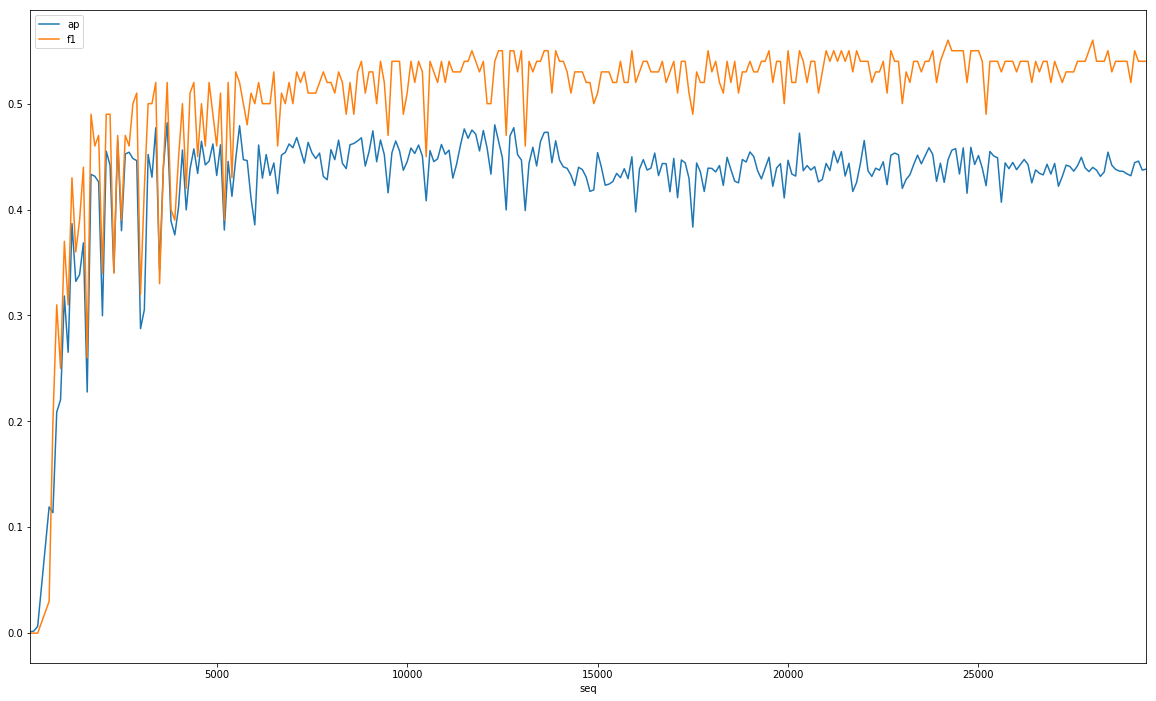

In [9]:
df_train = batch_perf('/mnt/ml-data4/error_analysis/baseline/1661.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/baseline/1661.out/*.weights.out')
# df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
df_val[['ap', 'f1']].plot()
df_val.ap.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
19900.0    0.52
23100.0    0.52
10400.0    0.51
11600.0    0.51
16000.0    0.51
17600.0    0.51
18600.0    0.51
19200.0    0.51
19500.0    0.51
20500.0    0.51
Name: f1, dtype: float64

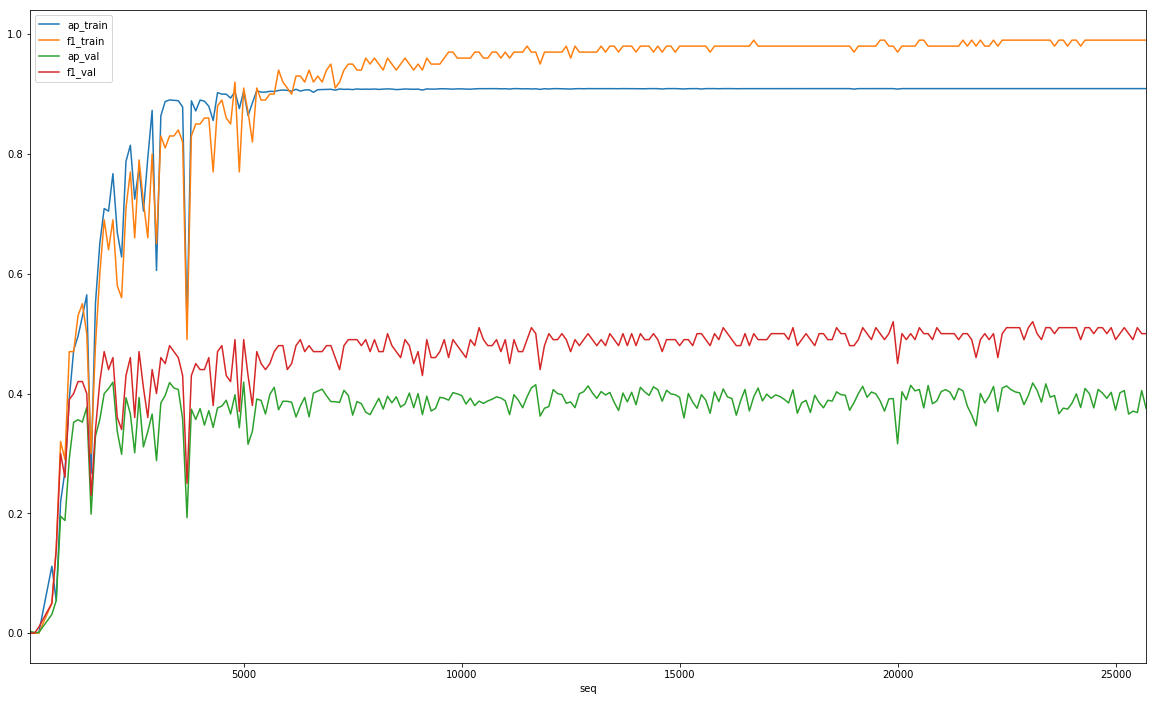

In [18]:
df_train = batch_perf('/mnt/ml-data4/error_analysis/baseline/800.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/baseline/800.out/*.weights.out')
df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
# df_val[['ap', 'f1']].plot()
df_val.f1.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
7900.0    0.47
9000.0    0.47
9100.0    0.47
9500.0    0.47
5700.0    0.46
6400.0    0.46
6700.0    0.46
7000.0    0.46
7700.0    0.46
7800.0    0.46
Name: f1, dtype: float64

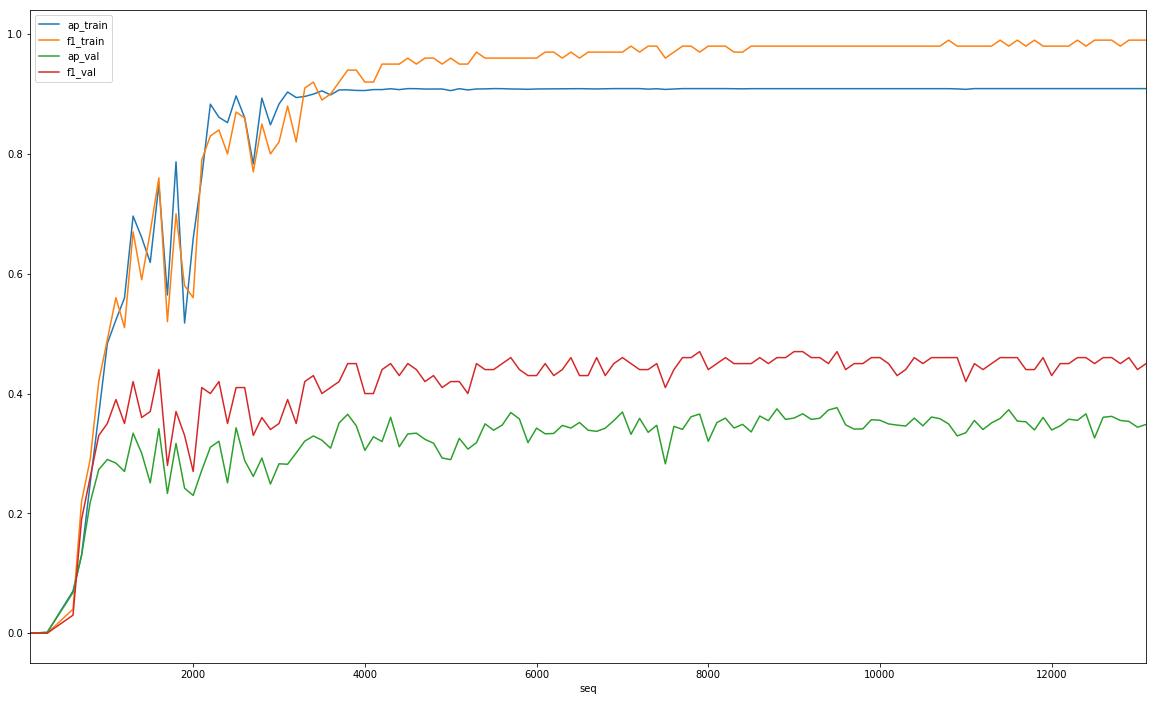

In [8]:
df_train = batch_perf('/mnt/ml-data4/error_analysis/baseline/400.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/baseline/400.out/*.weights.out')
df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
# df_val[['ap', 'f1']].plot()
df_val.f1.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


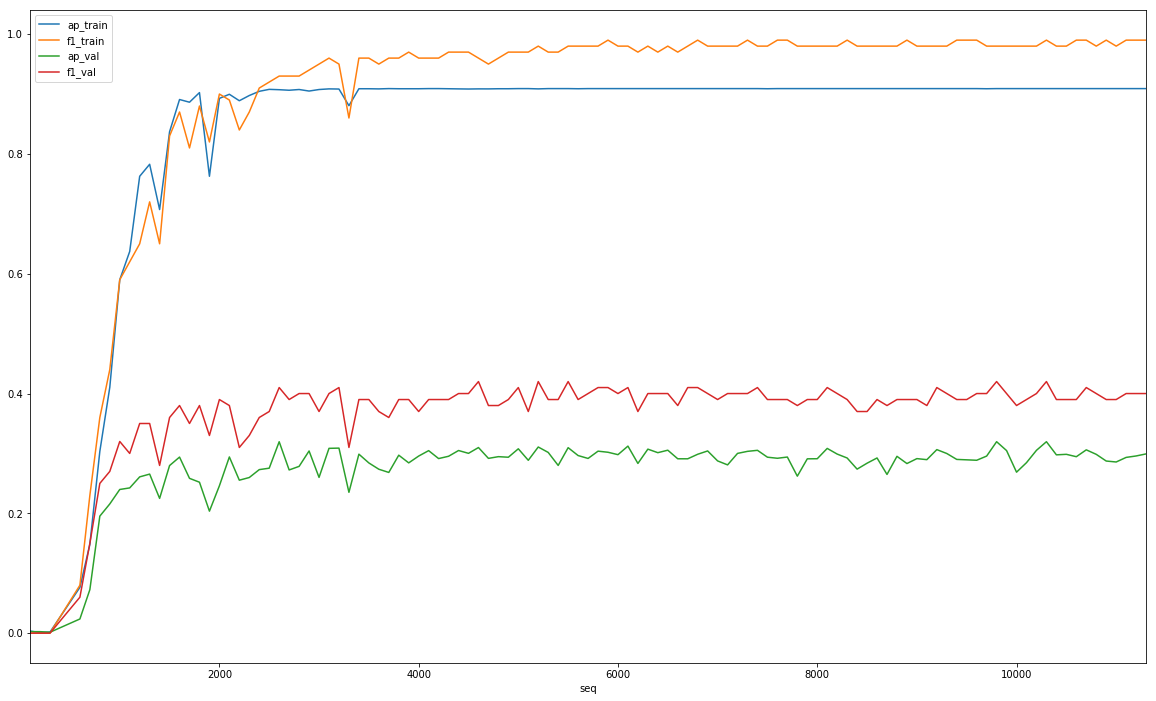

In [12]:
df_train = batch_perf('/mnt/ml-data4/error_analysis/baseline/200.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/baseline/200.out/*.weights.out')
df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
# df_val[['ap', 'f1']].plot()
# df_val.ap.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


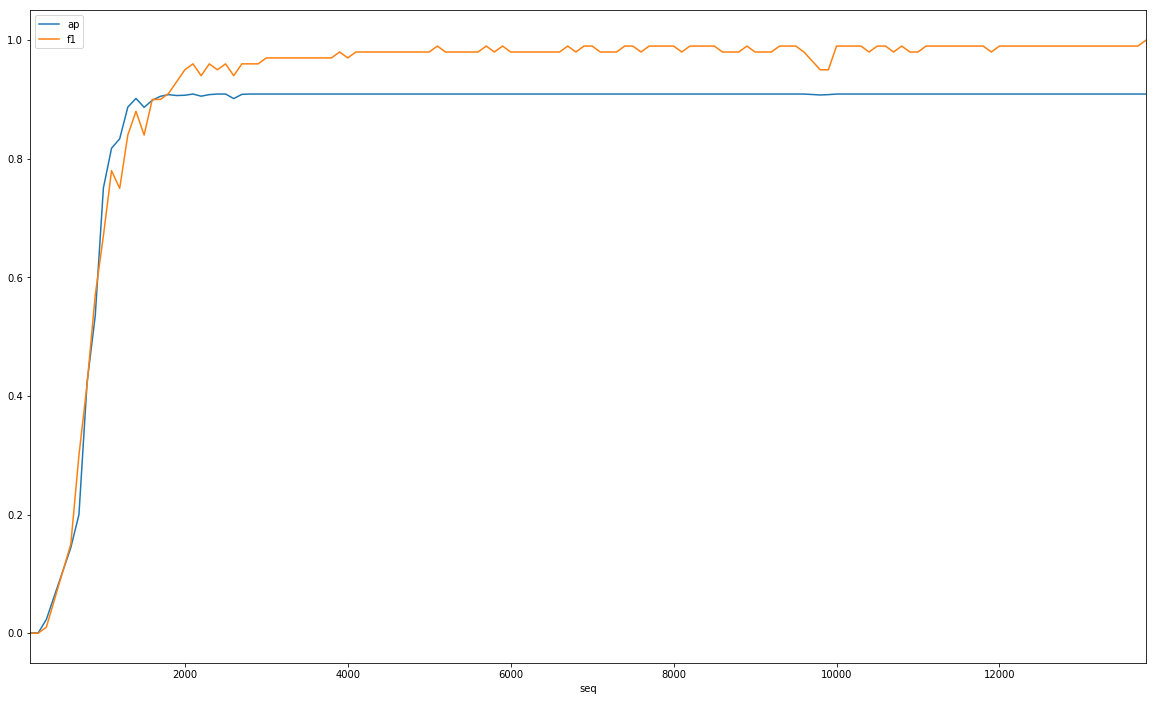

In [10]:
df_train = batch_perf('/mnt/ml-data4/error_analysis/baseline/100.train.out/*.weights.out')
# df_val = batch_perf('/mnt/ml-data1/BBox-Label-Tool/error_analysis/100.out/*.weights.out')
# df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
df_train[['ap', 'f1']].plot()
# df_val.ap.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
1700.0    0.526850
2300.0    0.519699
1800.0    0.504411
4600.0    0.496299
1400.0    0.495133
3600.0    0.491358
2400.0    0.489463
1900.0    0.488193
3400.0    0.487890
5600.0    0.486168
Name: ap, dtype: float64

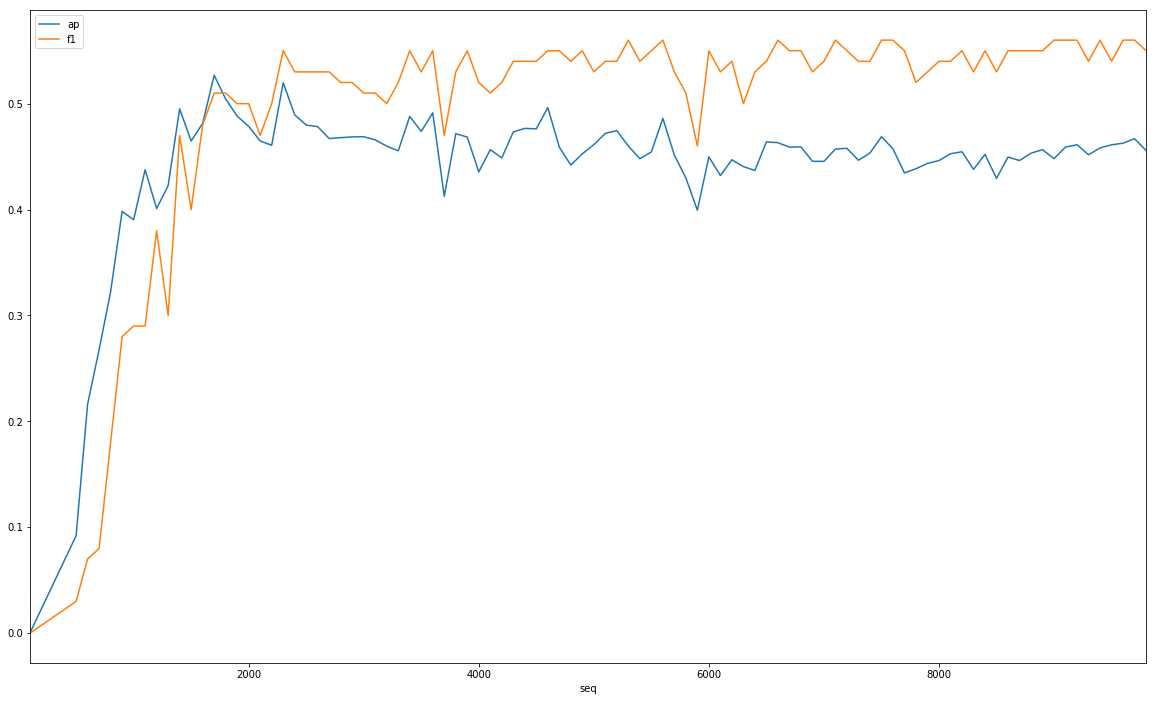

In [10]:
# df_train = batch_perf('/mnt/ml-data4/error_analysis/yolo/100.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/yolov3/1661.out/*.weights.out', seq_re="yolov3_([\d]+).weights.out")
# df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
df_val[['ap', 'f1']].plot()
df_val.ap.nlargest(10)

Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>
Unexpected error: <class 'AttributeError'>


seq
2700.0    0.521431
3900.0    0.520419
2600.0    0.518719
3300.0    0.516360
3200.0    0.513797
3400.0    0.512172
3100.0    0.512150
2200.0    0.509224
6100.0    0.507772
5200.0    0.505195
Name: ap, dtype: float64

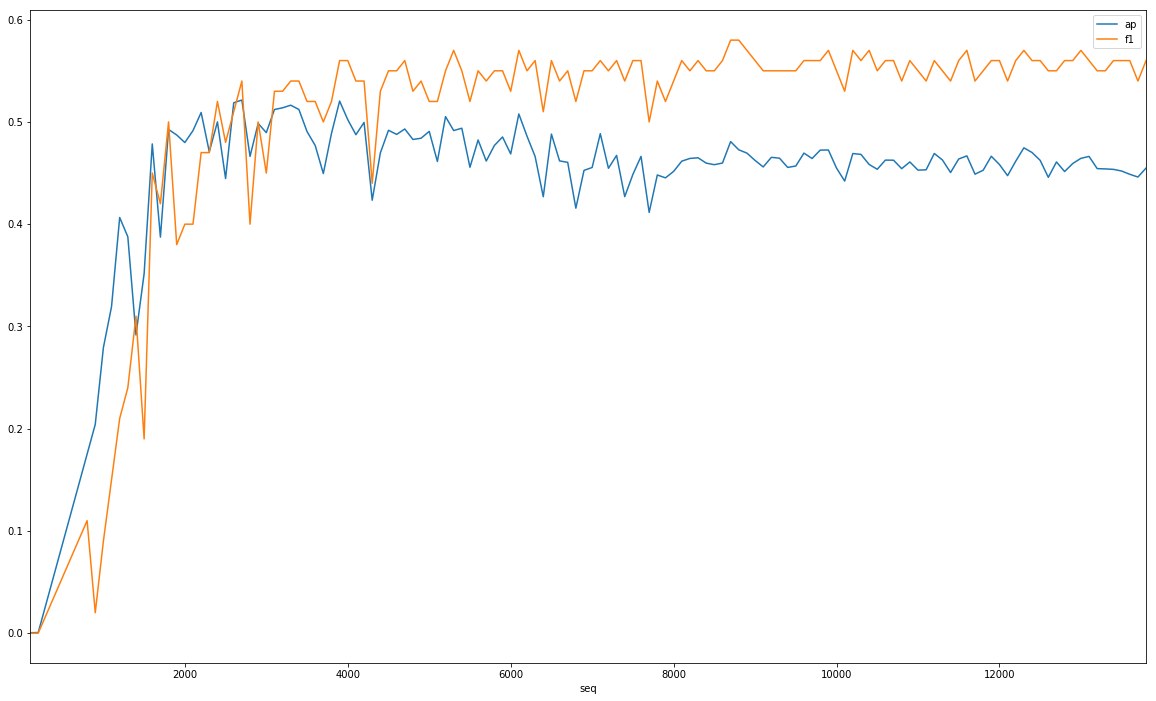

In [12]:
# df_train = batch_perf('/mnt/ml-data4/error_analysis/yolo/100.train.out/*.weights.out')
df_val = batch_perf('/mnt/ml-data4/error_analysis/yolov3/0.0002.out/*.weights.out', seq_re="yolov3_([\d]+).weights.out")
# df_train.merge(df_val, left_index=True, right_index=True, suffixes=('_train', '_val'))[['ap_train', 'f1_train', 'ap_val', 'f1_val']].plot()
df_val[['ap', 'f1']].plot()
df_val.ap.nlargest(10)